In [1]:
#import functions
%pylab inline

# from MyUnits import *
from MyFunctions import *
from qutip import *

# from MyQubit import *
# import mpld3
import multiprocessing as mp
import itertools
import datetime





Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.constants as sc

In [3]:
import time
import datetime

In [4]:


%%javascript
IPython.load_extensions('usability/codefolding/main');
IPython.load_extensions('toggle_all_line_number.js');

<IPython.core.display.Javascript object>

## Hamiltonian

In [5]:
N = 2
M = 2
P = 2
w_c = 5
w_nr = 3.5
g = 0.08
#L = 0.0012*4.5
#L = 0.0012*5.5
L = 0.0012*6.5
#L = 0.0012*7.5
Ej = 15
Ec = 0.223
w = 0
w_q_max = sqrt(8 * Ec * Ej) - Ec
print(w_q_max)
d = 0.10
A = 0.0002# field aplitude

# phi = linspace(0,pi/2,200)
x_i,x_f = 0.314,0.342
phi = 0.33
w_q =  sqrt( 8 * Ec * Ej* abs(cos(phi))*sqrt(1+(d*tan(phi))**2) )-Ec




kwargs = {'num_cpus':27,'energies':1, 'Ec':Ec}

4.95000686255


In [16]:
# Hamiltonians Functions
# Calc Spectrum

    
s11,s22,s33,s12,s32 = three_level_ops()
# dispersive Qubit CPW NR 
Delta = w_q - w_c
delta = w_q - w_nr
# qubit operators
s11,s22,s33,s12,s32 = three_level_ops()
v1,v2,v3 = three_level_basis()

Ts11 = tensor(s11,qeye(M),qeye(P))
Ts22 = tensor(s22,qeye(M),qeye(P))
Ts33 = tensor(s33,qeye(M),qeye(P))
Ts12 = tensor(s12,qeye(M),qeye(P))
Ts32 = tensor(s32,qeye(M),qeye(P))

Tv1 = tensor(v1,qeye(M),qeye(P))
Tv2 = tensor(v2,qeye(M),qeye(P))
Tv3 = tensor(v3,qeye(M),qeye(P))

I = tensor(qeye(3),qeye(M),qeye(P))





#     sm = tensor(create(2),qeye(M),qeye(P))
#     sz = tensor(sigmaz(),qeye(M),qeye(P))
#     sx = tensor(sigmax(),qeye(M),qeye(P))
#     nq = sm.dag() * sm
#     xq = sm + sm.dag()
#     I = tensor(qeye(2), qeye(M),qeye(P))


# mechanical resonator operators

b = tensor(qeye(3),destroy(M),qeye(P))
n_b = b.dag() * b
x_b = b.dag() + b
p_b = b - b.dag()


# CPW operators

c = tensor(qeye(3),qeye(M),destroy(P))
n_c = c.dag() * c
x_c = c.dag() + c
p_c = c - c.dag()

# Identity



#      Hamiltonian

H3 = (w_q - w ) * Ts22 + (2 * w_q - Ec - w) * Ts33


H1 = (w_nr - w )* (b.dag() * b ) + L * (b.dag() * ( Ts12 + sqrt(2) * Ts32.dag() ) 
                                        + b * ( Ts12.dag() + sqrt(2) * Ts32 )
                                       )


H2 = (w_c - w) * (c.dag() * c )  + g * ( c.dag()*(Ts12 + sqrt(2) * Ts32.dag()) 
                                        + c*(Ts12.dag() + sqrt(2) * Ts32)
                                       )


H4 = A * (c.dag() + c)


#     Colapse Operators

c_op_list = []

#kappa_n =0.00025 # cavity
#kappa_n =0.0004 # cavity
kappa_n =0.0012 # cavity
#kappa_n =0.002 # cavity

gamma_rel = 200*0.0002 # qubit
gamma_dep = 0.001 # qubit

Gamma_m = 0*0.01 # MR


Ta = 60e-3 #k
Tq = 30e-3 #K

#Tb = 30e-3 #k
#Tb = 60e-3 #k
Tb = 100e-3 #k
#Tb = 300e-3 #k



n_th_a = 1/(exp(sc.h*w_q*1e9/(sc.k*Ta)-1))

n_th_q = 1/(exp(sc.h*w_q*1e9/(sc.k*Tq)-1))

if Tb == 0:
     n_th_b = 0
else:

    n_th_b = 1/(exp(sc.h*w_nr*1e9/(sc.k*Tb)-1))

# cavity
c_op_list = []

rate = kappa_n * (1 + n_th_a)
if rate > 0.0:
    c_op_list.append(sqrt(rate) * c)

rate = kappa_n * n_th_a
if rate > 0.0:
    c_op_list.append(sqrt(rate) * c.dag())

rate = gamma_rel * (1 + n_th_q)
if rate > 0.0:
    c_op_list.append(sqrt(rate) * (Ts12 + sqrt(2) * Ts32.dag())
                    )

rate = gamma_rel * (n_th_q)
if rate > 0.0:
    c_op_list.append(sqrt(rate) * (Ts12.dag() + sqrt(2) * Ts32)
                    )

rate = gamma_dep / 2 * (1 + n_th_q)
if rate > 0.0:
    c_op_list.append(sqrt(rate) * (Ts22 + sqrt(2) * Ts33))

rate = Gamma_m * (1 + n_th_b)
if rate > 0.0:
    c_op_list.append(sqrt(rate) * b)

rate = Gamma_m * n_th_b
if rate > 0.0:
    c_op_list.append(sqrt(rate) * b.dag())    

    
# Solution Type    



In [29]:
tlist = linspace(0,100,1000)   
rho = tensor(s11,thermal_dm(M,0),thermal_dm(P,0))
H0 = H1 + H2 + H3 + H4 #+ H5
    

In [30]:
# res = mesolve(H1, rho, tlist, [], [], options=Odeoptions(nsteps=5000),progress_bar= True) #H, rho0, tlist, c_ops, e_ops, args={}, options=None, progress_bar=None
output = mesolve(H0, rho, tlist, c_op_list, [c])


In [32]:
shape(output.expect[0])

(1000,)

In [36]:
# Energies


# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)



# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 

try:
    t_start = time.time() # start time simulation
    time_1 = []
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_6,(N,
                                                 M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 a1,
                                                 L,
                                                 g,
                                                 A,
                                                 w),kwargs
                                ,callback=None,error_callback=None) for a1 in x_vec]



    #####N,M,P, w_c,w_nr, w_q,L,g,A,w=0
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nTotal time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count-  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e




energies_temp = [ar.get() for ar in results]
energies = asarray(energies_temp)





Parallel Simulation with 27 CPUs 
[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s
All done! 
Total time:0:00:00


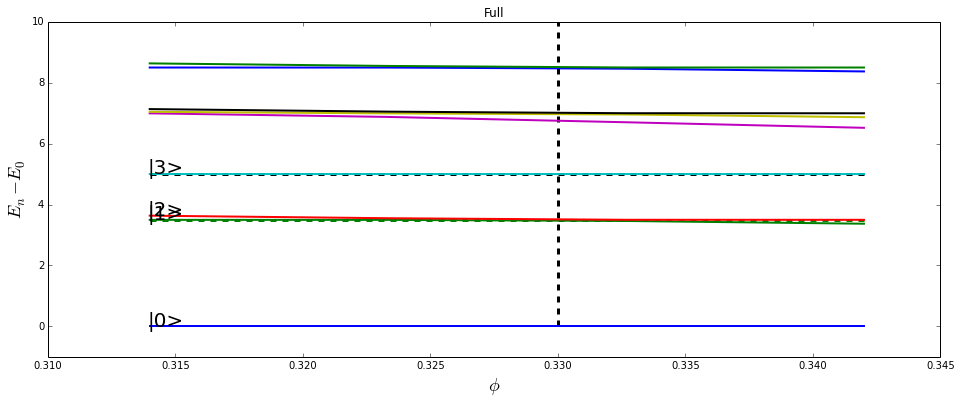

In [37]:
# Plot 
fig, axes = subplots(1,1, figsize=(16,6))
x_inf = -1
x_sup = 10

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=2)
#     axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
    if n < 4:
        axes.text(x_i,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(x_inf, x_sup)
axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'$E_n-E_0$', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed',linewidth=3,color='green')
axes.hlines(w_c,x_i,x_f,linestyles='dashed',linewidth=3)
axes.vlines(0.33,0,10,linestyles='dashed',linewidth=3)






In [38]:
y_i,y_f = 4.994,5.008
y_vec = linspace(y_i,y_f,4) 
a , b = zip(*itertools.product(x_vec,y_vec))
kwargs = {'num_cpus':2,'dispersive':1, 'Ec':Ec}

In [39]:
# Run Spectrum
# Create from the original vectors the new vector with the correct number copies
a , b = zip(*itertools.product(x_vec,y_vec))
# variable to count the total number of tasks we need to do; used to create progress bar
task_count =len(x_vec)*len(y_vec)

# Check number of cpus to be used
if 'num_cpus' in kwargs:
    num_cpu = kwargs['num_cpus']
    if num_cpu == 1:
        print("1 CPU; Serial Simulation")
    else:
        print("Parallel Simulation with %d CPUs " % num_cpu)    
else:
    num_cpu = 1
    print("Serial Simulation")



## Program to run function in parallel: 
t_start = time.time() # start time simulation
time_1 = []
try:
    pool = mp.Pool(processes=num_cpu) #  create the initial pool to run the simulation   
#         manager = mp.Manager()
#         queue = manager.Queue()


#         _update_progress_bar(1)
#     task_args = a,z
    results = [pool.apply_async(calc_spectrum_6,(N,
                                                 M,
                                                 P,
                                                 w_c,
                                                 w_nr,
                                                 a1,
                                                 L,
                                                 g,
                                                 A,
                                                 b1),kwargs
                                ,callback=None,error_callback=None) for a1,b1 in zip(a,b)]



        #####
    while True:
        incomplete_count = sum(1 for x in results if not x.ready())

        if incomplete_count == 0:
            print("[100.0%] of the simulations calculated, Estimated Remaining time: 0.0s", end="\r")
            print( "\nAll done! \nMean time:%f"%(dif_time/task_count))
            print( "\nTotal time:%s"%datetime.timedelta(seconds=int(dif_time)))
            break

        else:

            p = float(task_count - incomplete_count) / task_count * 100 

            dif_time = (time.time() - t_start)    

#                 
            if p > 0:
                rem_time = (datetime.timedelta(seconds=int(dif_time*(100-p)/p)))

#                     rem_time_1 = (datetime.timedelta(seconds=int(dif_time/(task_count-incomplete_count))))
                time_1.append(float(dif_time/(task_count -  incomplete_count)))
#                     rem_time_1 = mean(time_1) *task_count
#                     rem_time_1 = (datetime.timedelta( seconds=int(mean(time_1) *task_count)))
                rem_time_1 = time.strftime("%Z - %Y/%m/%d, %H:%M:%S", time.localtime(t_start+mean(time_1) *task_count))
            else:
                rem_time = '?'
                rem_time_1 = 0


            print("[%4.1f%%] of the simulations calculated, Estimated Remaining time: %s, (%s)"
                  %(p,rem_time,rem_time_1) , end="\r")

            time.sleep(.25)


    while not all([ar.ready() for ar in results]):

        for ar in results:    
            ar.wait(timeout=0.1)

    pool.terminate()
    pool.join()

except KeyboardInterrupt as e:
    pool.terminate()
    pool.join()
    raise e




results = [ar.get() for ar in results]



Parallel Simulation with 2 CPUs 


KeyboardInterrupt: 

In [40]:
results

In [169]:
# Reshape Results
#results = qload('Two_Dispersive_Simulation')
results_1 = asarray(results)
#qsave(results,name='k1200L3T100')
#qsave(results,name='Two_Dispersive_Simulation')
# qsave(results,name='ThirtytyVolts')

tr_c = reshape(results_1[:,0],(-1,len(y_vec+1)))

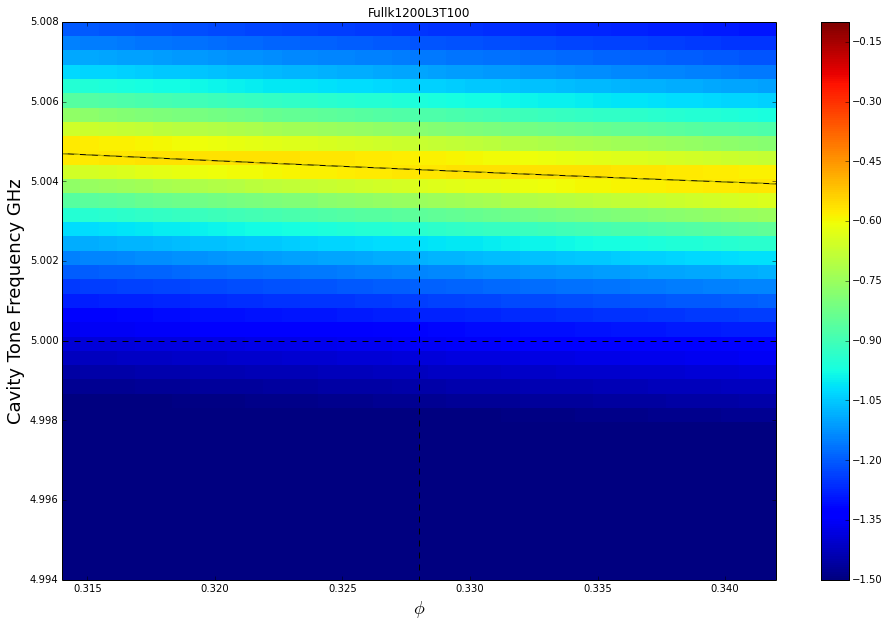

In [170]:
# Plot Graphic II
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=1)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Fullk1200L3T100')
axes.set_ylim(y_inf, y_sup)
axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
# axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
axes.vlines(0.328,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))),vmin=-1.5,vmax=-0.1)#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

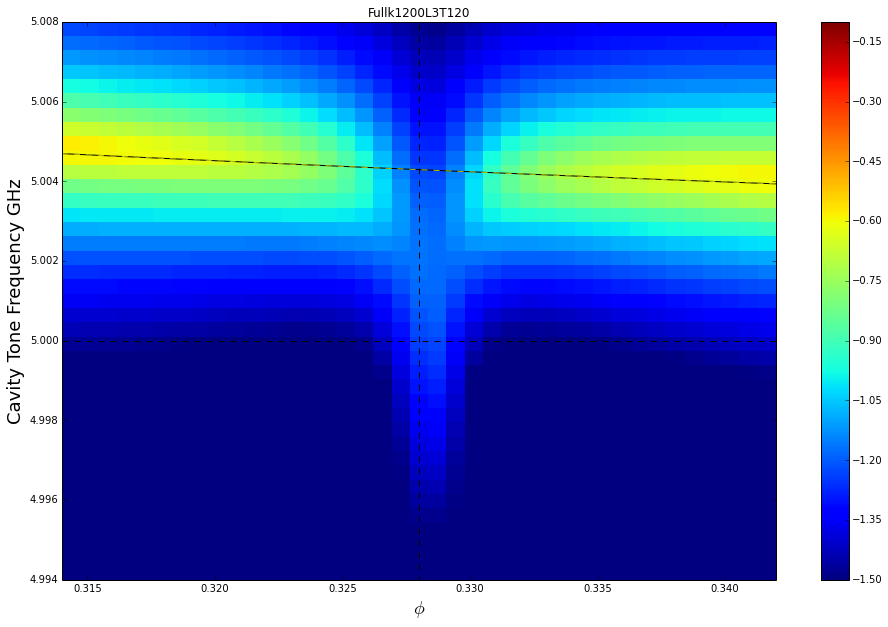

In [19]:
# Plot Graphic II
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=1)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Fullk1200L3T120')
axes.set_ylim(y_inf, y_sup)
axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
# axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
axes.vlines(0.328,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))),vmin=-1.5,vmax=-0.1)#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

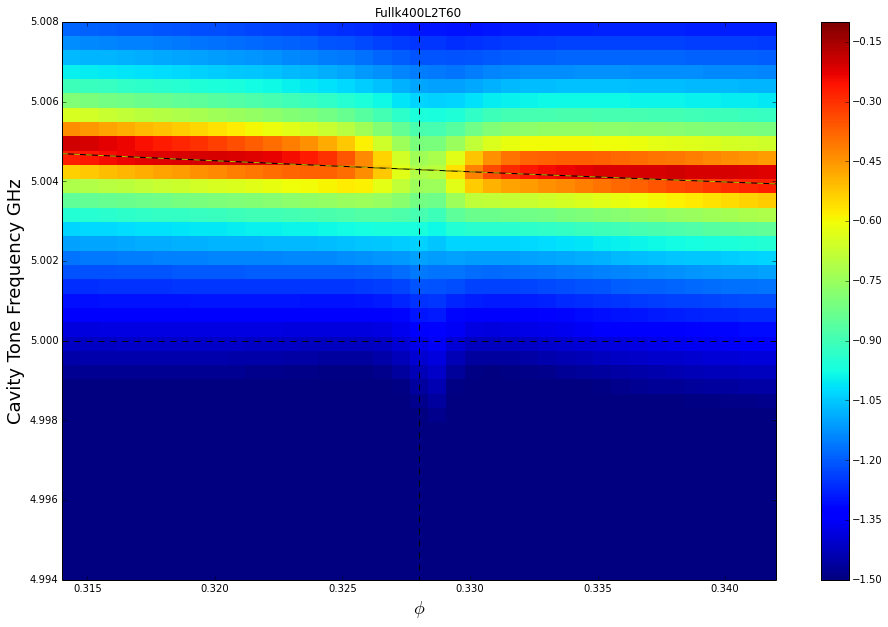

In [29]:
# Plot Graphic II
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=1)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Fullk400L2T60')
axes.set_ylim(y_inf, y_sup)
axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
# axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
axes.vlines(0.328,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))),vmin=-1.5,vmax=-0.1)#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

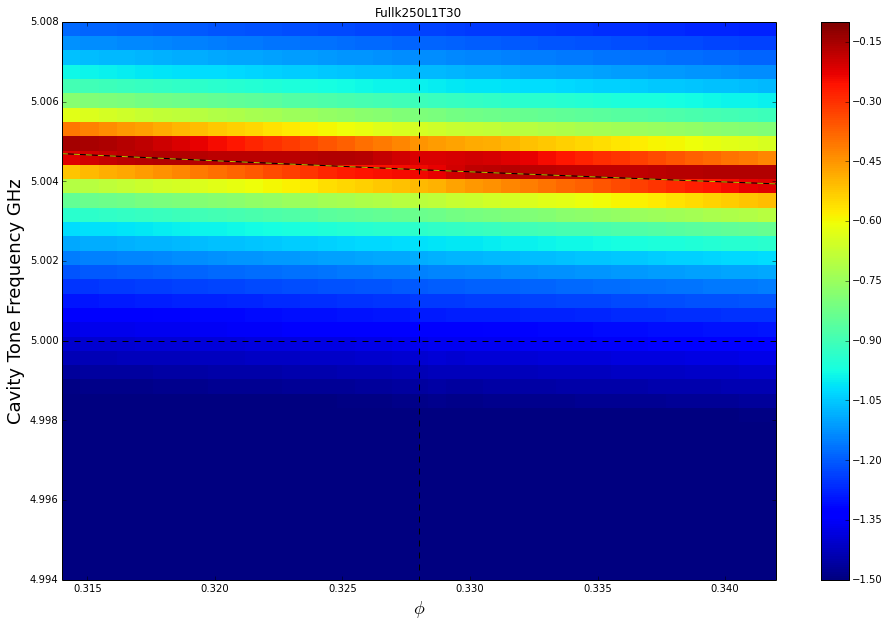

In [37]:
# Plot Graphic II
fig, axes = subplots(1,1, figsize=(16,10))
y_inf = y_i
y_sup = y_f
x_inf = x_i
x_sup = x_f

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-',linewidth=1)
    axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Fullk250L1T30')
axes.set_ylim(y_inf, y_sup)
axes.set_xlim(x_inf,x_sup)


axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,x_i,x_f,linestyles='dashed')
axes.hlines(w_c,x_i,x_f,linestyles='dashed')
# axes.vlines(0.245,0,10,linestyles='dashed',linewidth=3)
axes.vlines(0.328,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,y_vec,transpose(log10(abs(tr_c))),vmin=-1.5,vmax=-0.1)#axes.pcolor(phi/pi,y_vec,transpose((abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)